In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from pathlib import Path
import rasterio
import pandas as pd
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

/home/bertille/miniconda3/envs/ecomed_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class EcomedDataset(Dataset):
    def __init__(self, msk_paths, img_dir, level=1):
        self.img_dir = img_dir
        self.level = level
        self.msks = msk_paths
        self.imgs = [self.img_dir / msk_path.parts[-2] / msk_path.name.replace('msk', 'img').replace('l123/', '') for msk_path in self.msks]
                
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        msk_path = self.msks[idx]
        with rasterio.open(msk_path) as src:
            msk = src.read(self.level)
            # to torch long
        with rasterio.open(img_path) as src:
            img = src.read()
            # turn to values betw 0 and 1 and to float
            # linear normalisation with p2 and p98
            p2, p98 = np.percentile(img, (2, 98))
            img = np.clip(img, p2, p98)
            img = (img - p2) / (p98 - p2)
            img = img.astype(np.float32)
        return img, msk

        #img = img.astype(np.int16)
        #return img, msk

In [5]:
# ask if gpu available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

model = smp.Unet(
    encoder_name="efficientnet-b7",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=4,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=6,                      # model output channels (number of classes in your dataset)
)

settings_dict = {
    'patch_size': 256, 
    'level': 1, 
    'bs': 16,
    'shuffle': 'random', 
    'random_seed': 42,
    'nb_epochs': 10,
}
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Using device: cuda


In [6]:
img_folder = Path(f'../data/patch{settings_dict["patch_size"]}/img/')
msks_256_fully_labelled = pd.read_csv('../csv/coverage_patch/l1_256_100per_labelled.csv')
msk_paths = list(msks_256_fully_labelled['mask_path'])
msk_paths_ = [Path(p) for p in msk_paths]
msk_paths = []

# KEEP ONLY EXISTING MASKS PATHS (THE ONES WITH INVALID DATES)
for msk_path in msk_paths_:
    if msk_path.exists():
        msk_paths.append(msk_path)

# BUILD TE IMG PATHS CORRESPONDING TO THE MASKS PATHS
img_paths = [img_folder / msk_path.parts[-2] / msk_path.name.replace('msk', 'img').replace('l123/', '') for msk_path in msk_paths]

# CHECK IF THE IMAGES HAVE ZERO VALUES
imgs_zero_paths = []
for img_path in img_paths:
    with rasterio.open(img_path) as src:
        img = src.read()
    if np.count_nonzero(img) == 0:
        imgs_zero_paths.append(img_path)

msk_folder = Path(f'../data/patch{settings_dict["patch_size"]}/msk/l123')

# LOOK FOR MASKS MATCHING THE IMAGES WITH ZERO VALUES
msks_paths_zero = [msk_folder / img_path.parts[-2] / img_path.name.replace('img', 'msk') for img_path in imgs_zero_paths]

final_msk_paths = []

for msk_path in msk_paths:
    if msk_path in msks_paths_zero:
        continue
    final_msk_paths.append(msk_path)

# Shuffle with random_seed fixed and split in 60 20 20
np.random.seed(42)
np.random.shuffle(final_msk_paths)
n = len(final_msk_paths)
train_paths = final_msk_paths[:int(0.6*n)]
val_paths = final_msk_paths[int(0.6*n):int(0.8*n)]
test_paths = final_msk_paths[int(0.8*n):]

# Just to check the pipeline is good
train_paths = train_paths
val_paths = val_paths
test_paths = test_paths

# Create a dataloader for level 1
train_ds = EcomedDataset(train_paths, img_folder, level=settings_dict['level'])
train_dl = DataLoader(train_ds, batch_size=settings_dict['bs'], shuffle=True)
val_ds = EcomedDataset(val_paths, img_folder, level=settings_dict['level'])
val_dl = DataLoader(val_ds, batch_size=settings_dict['bs'], shuffle=False)
test_ds = EcomedDataset(test_paths, img_folder, level=settings_dict['level'])
test_dl = DataLoader(test_ds, batch_size=settings_dict['bs'], shuffle=False)

/home/bertille/miniconda3/envs/ecomed_venv/lib/python3.12/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [7]:
# Sanity check of the dataloader
for img, msk in train_dl:
    print(img.shape, msk.shape)
    break
    

torch.Size([16, 4, 256, 256]) torch.Size([16, 256, 256])


In [8]:
def IoU(pred, target):
    i = torch.sum(pred & target)
    u = torch.sum(pred | target)
    return i/u

def train(model, train_dl, criterion, optimizer, device):
    print('Training')
    running_loss = 0.0
    tr_IoUs = []
    for i, (img, msk) in enumerate(train_dl):
        if i % 50 == 0:
            print( 'Batch:', i, ' over ', len(train_dl))
        img, msk = img.to(device), msk.to(device)
        optimizer.zero_grad()
        out = model(img)
        msk = msk.long()
        loss = criterion(out, msk)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        out = torch.argmax(out, dim=1)
        out = out.int()
        tr_IoUs.append(IoU(out, msk))
    tr_IoUs = [x.item() for x in tr_IoUs]
    mIoU = np.mean(tr_IoUs)
    return running_loss / len(train_dl), mIoU


def valid(model, val_dl, criterion, device):
    print('Validation')
    running_loss = 0.0
    val_IoUs = []
    for i, (img, msk) in enumerate(val_dl):
        if i % 50 == 0:
            print( 'Batch:', i, ' over ', len(val_dl))
        img, msk = img.to(device), msk.to(device)
        out = model(img)
        msk = msk.long()
        loss = criterion(out, msk)
        running_loss += loss.item()
        out = torch.argmax(out, dim=1)
        out = out.int()
        val_IoUs.append(IoU(out, msk))
    val_IoUs = [x.item() for x in val_IoUs]
    mIoU = np.mean(val_IoUs)
    return running_loss / len(val_dl), mIoU

def test(model, test_dl, criterion, device):
    print('Testing')
    running_loss = 0.0
    test_IoUs = []
    for i, (img, msk) in enumerate(test_dl):
        if i % 50 == 0:
            print( 'Batch:', i, ' over ', len(test_dl))
        img, msk = img.to(device), msk.to(device)
        out = model(img)
        msk = msk.long()
        loss = criterion(out, msk)
        running_loss += loss.item()
        out = torch.argmax(out, dim=1)
        out = out.int()
        test_IoUs.append(IoU(out, msk))
    test_IoUs = [x.item() for x in test_IoUs]
    mIoU = np.mean(test_IoUs)
    return running_loss / len(test_dl), mIoU

In [18]:
training_losses = []
validation_losses = []
training_iou = []
validation_iou = []
for epoch in range(settings_dict['nb_epochs']):
    print(f'Epoch {epoch+1}/{settings_dict["nb_epochs"]}')
    model.to(device)
    model.train()
    train_loss, train_mIoU = train(model, train_dl, criterion, optimizer, device)
    training_losses.append(train_loss)
    training_iou.append(train_mIoU)

    model.eval()
    with torch.no_grad():
        val_loss, val_mIoU = valid(model, val_dl, criterion, device)    
        validation_losses.append(val_loss)
        validation_iou.append(val_mIoU)

    print(f'Epoch {epoch+1}/{settings_dict["nb_epochs"]}: train loss {train_loss:.4f}, val loss {val_loss:.4f}')
    print(f'Epoch {epoch+1}/{settings_dict["nb_epochs"]}: train mIoU {train_mIoU:.4f}, val mIoU {val_mIoU:.4f}')

    if epoch % 2 == 0:
        torch.save(model.state_dict(), f'../models/unet_{epoch}.pt')
        

Epoch 1/10
Training
Batch: 0  over  347


/home/bertille/miniconda3/envs/ecomed_venv/lib/python3.12/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Batch: 50  over  347
Batch: 100  over  347
Batch: 150  over  347
Batch: 200  over  347
Batch: 250  over  347
Batch: 300  over  347


/home/bertille/miniconda3/envs/ecomed_venv/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Validation
Batch: 0  over  116
Batch: 50  over  116
Batch: 100  over  116
Epoch 1/10: train loss 1.1570, val loss 1.6197
Epoch 2/10
Training
Batch: 0  over  347
Batch: 50  over  347
Batch: 100  over  347
Batch: 150  over  347
Batch: 200  over  347
Batch: 250  over  347
Batch: 300  over  347
Validation
Batch: 0  over  116
Batch: 50  over  116
Batch: 100  over  116
Epoch 2/10: train loss 1.0870, val loss 1.0265
Epoch 3/10
Training
Batch: 0  over  347
Batch: 50  over  347
Batch: 100  over  347
Batch: 150  over  347
Batch: 200  over  347
Batch: 250  over  347
Batch: 300  over  347
Validation
Batch: 0  over  116
Batch: 50  over  116
Batch: 100  over  116
Epoch 3/10: train loss 1.0283, val loss 1.0615
Epoch 4/10
Training
Batch: 0  over  347
Batch: 50  over  347
Batch: 100  over  347
Batch: 150  over  347
Batch: 200  over  347
Batch: 250  over  347
Batch: 300  over  347
Validation
Batch: 0  over  116
Batch: 50  over  116
Batch: 100  over  116
Epoch 4/10: train loss 1.0088, val loss 0.9418
Epo

In [19]:
# save last model state and optim
torch.save(model.state_dict(), f'../models/unet_last_10.pt')
torch.save(optimizer.state_dict(), f'../models/optim_last_10.pt')


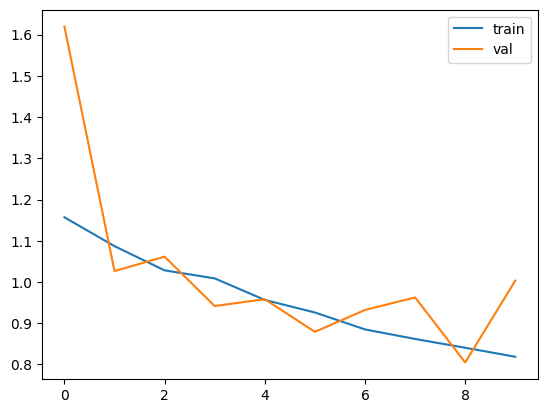

In [20]:
#plot losses
plt.plot(training_losses, label='train')
plt.plot(validation_losses, label='val')
plt.legend()
plt.show()

In [21]:
# get miou on tr and val    
print(f'Training mIoU: {train_mIoU:.4f}') # after 10 epochs
print(f'Validation mIoU: {val_mIoU:.4f}') #after 10 epochs

Training mIoU: 0.7094
Validation mIoU: 0.6827


In [24]:
# test
model.eval()
with torch.no_grad():
    test_loss, test_mIoU = test(model, test_dl, criterion, device)
print(f'Test mIoU: {test_mIoU:.4f}')

Testing
Batch: 0  over  116


/home/bertille/miniconda3/envs/ecomed_venv/lib/python3.12/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Batch: 50  over  116
Batch: 100  over  116
Test mIoU: 0.6977


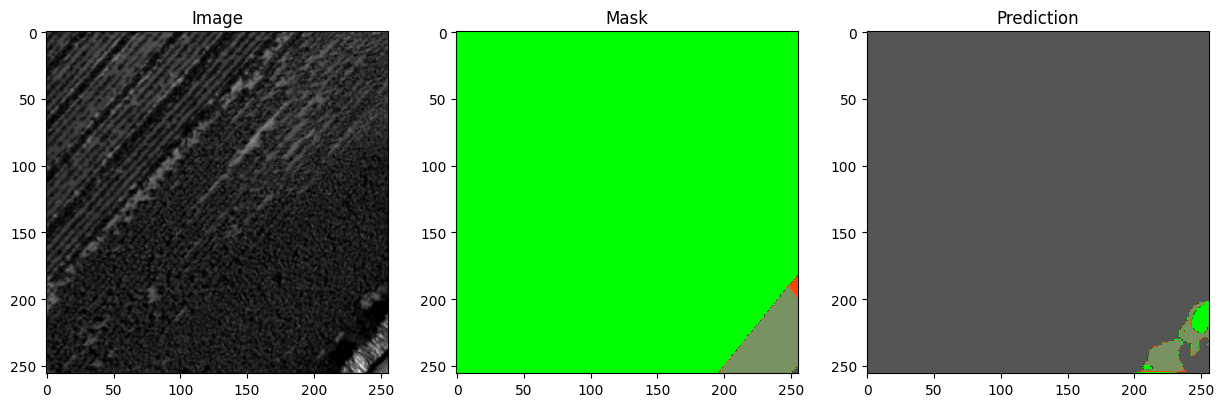

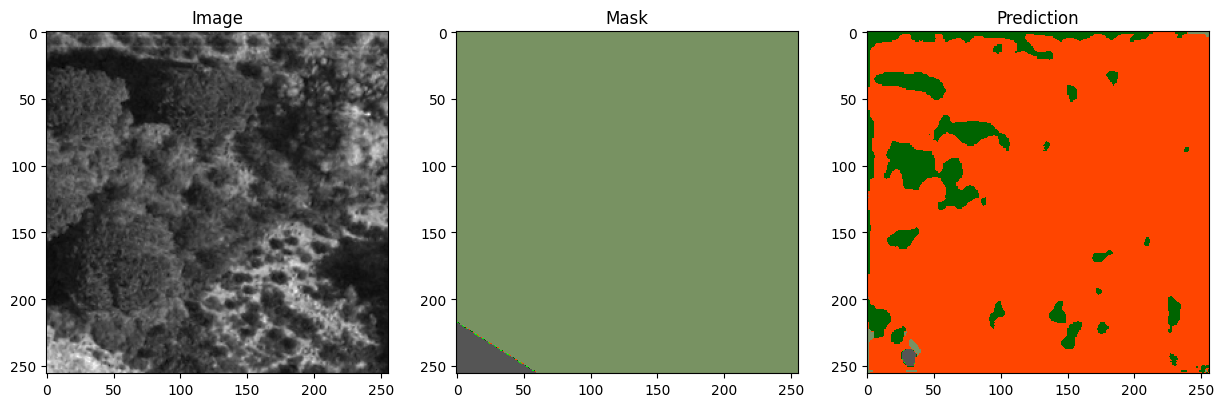

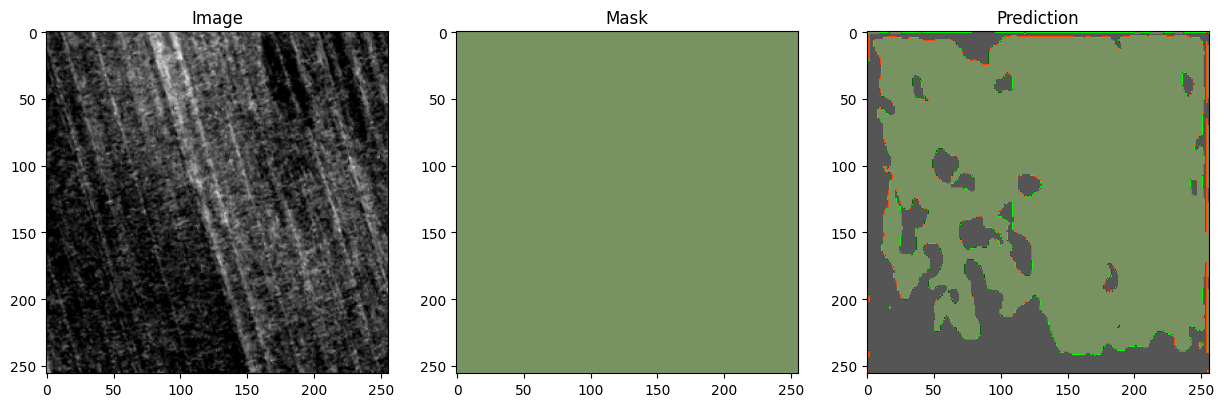

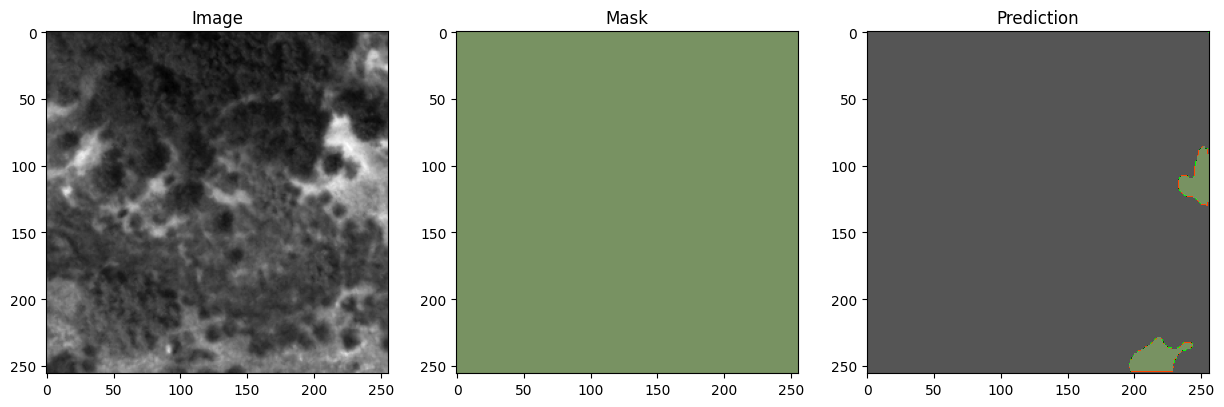

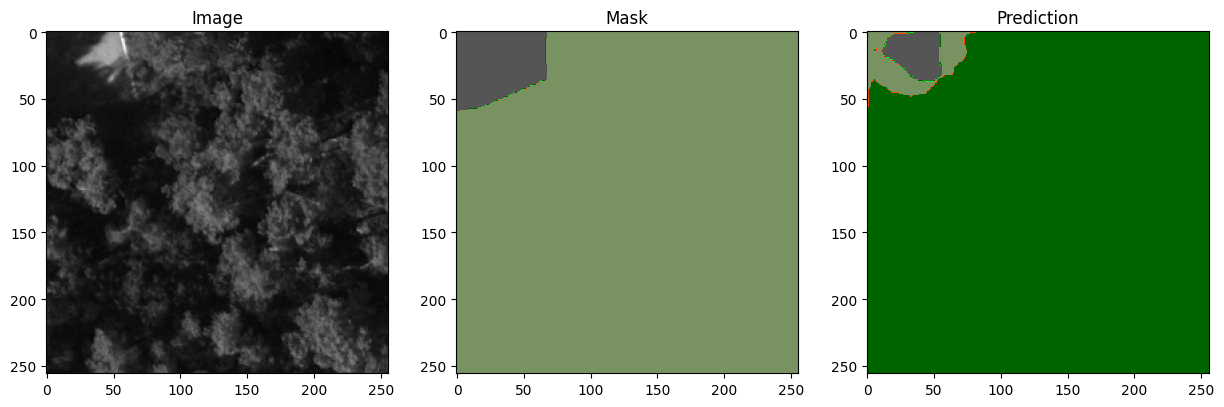

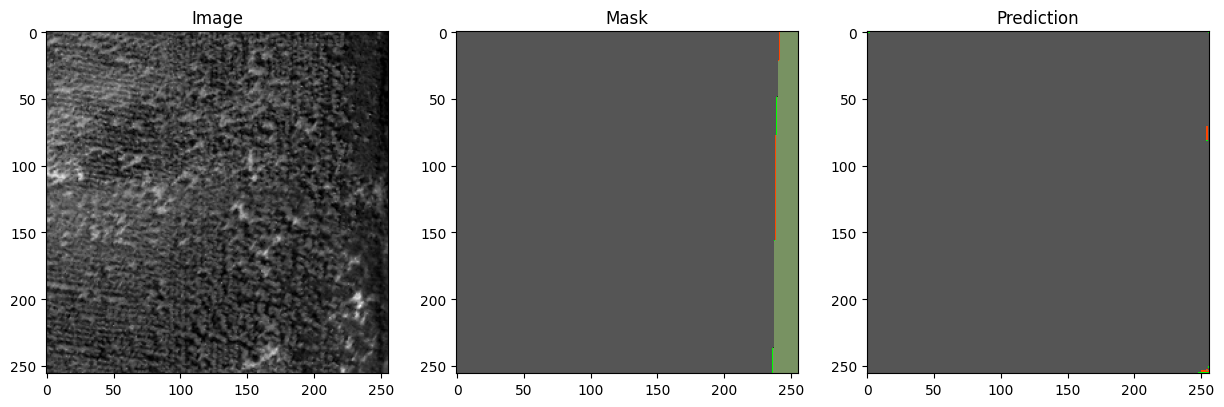

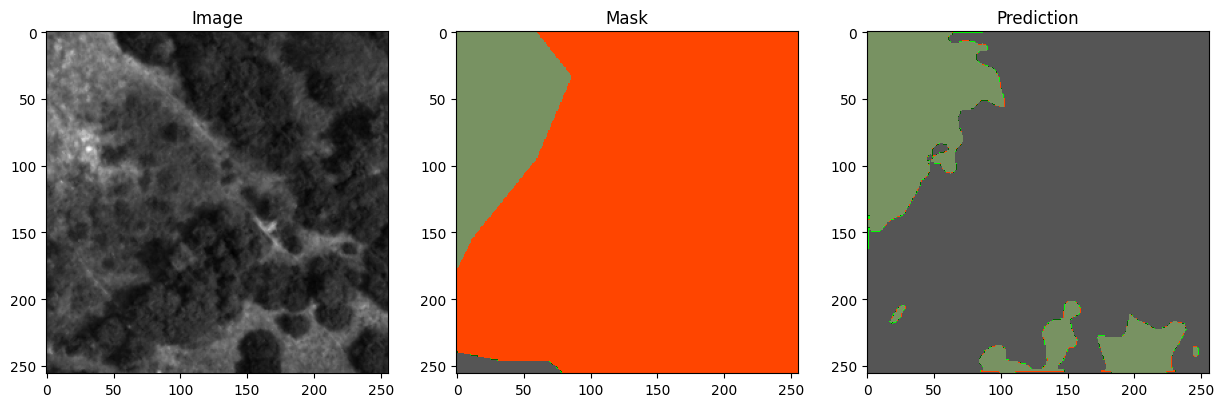

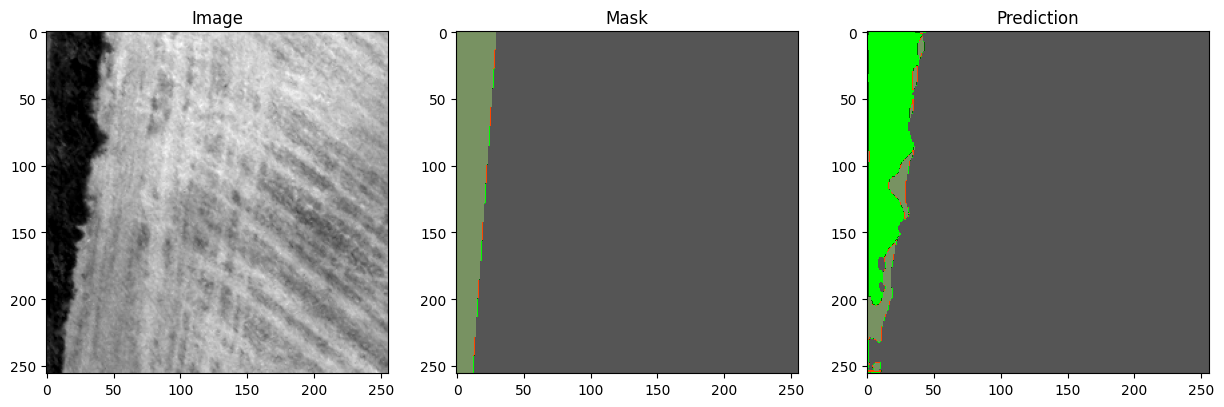

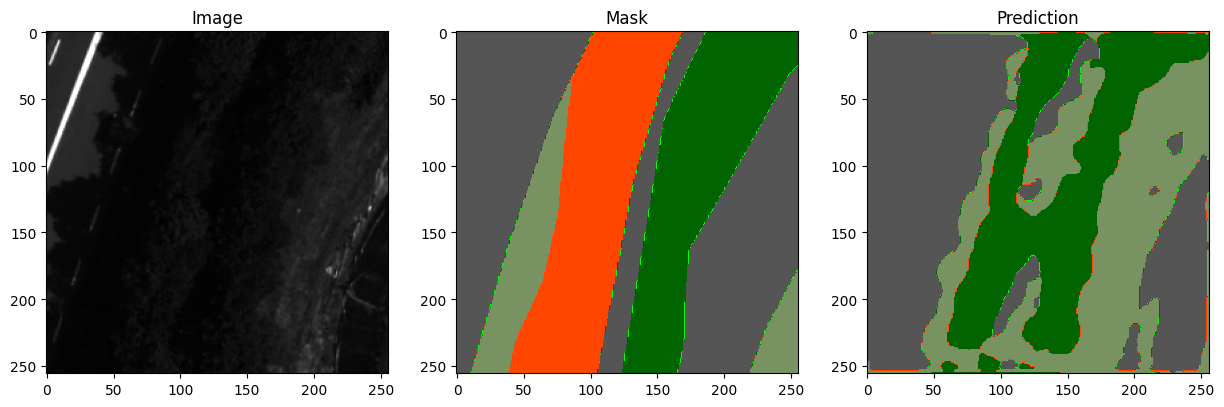

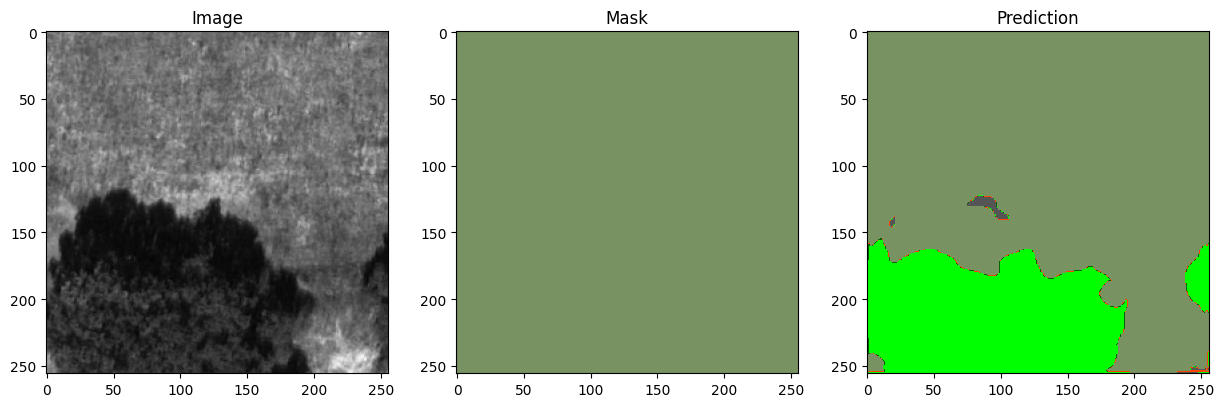

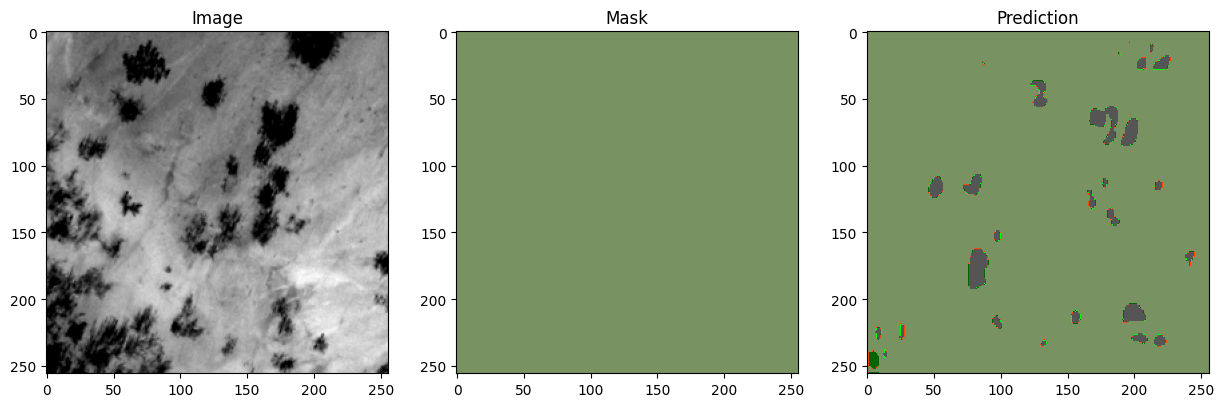

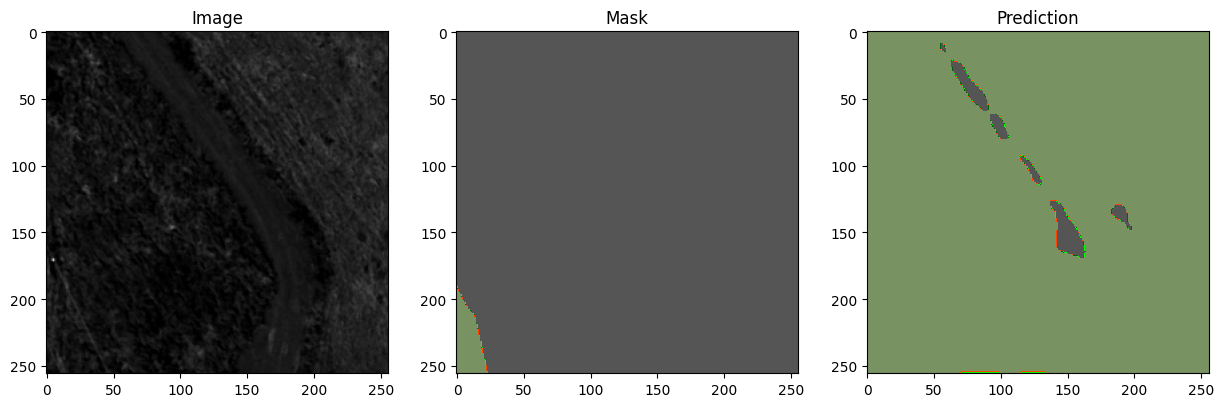

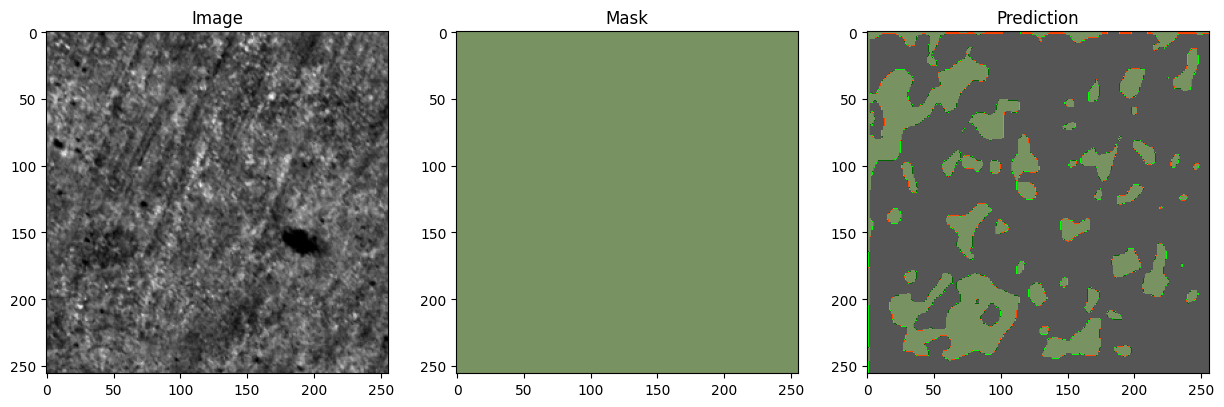

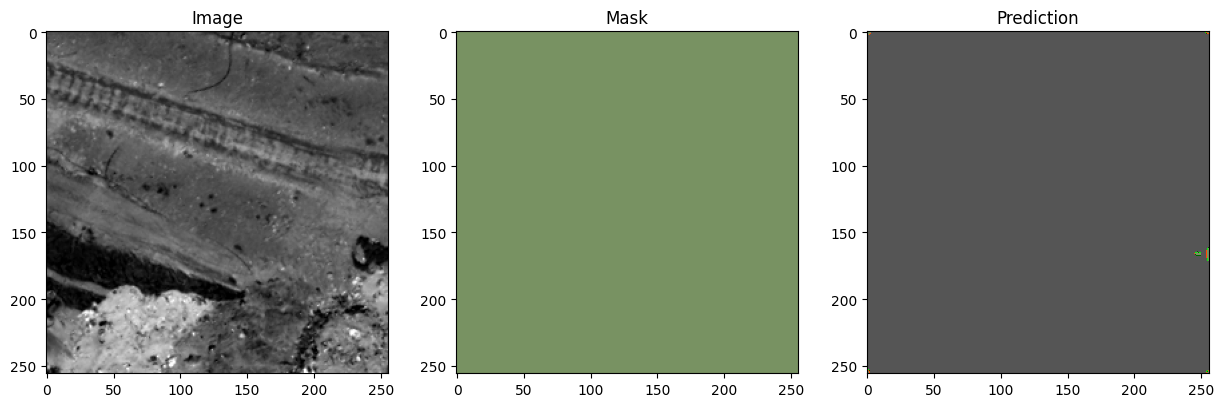

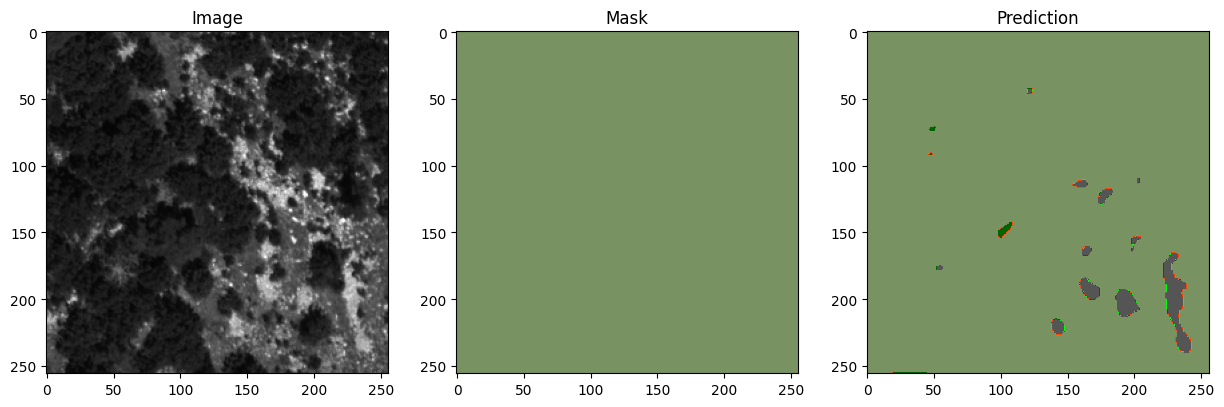

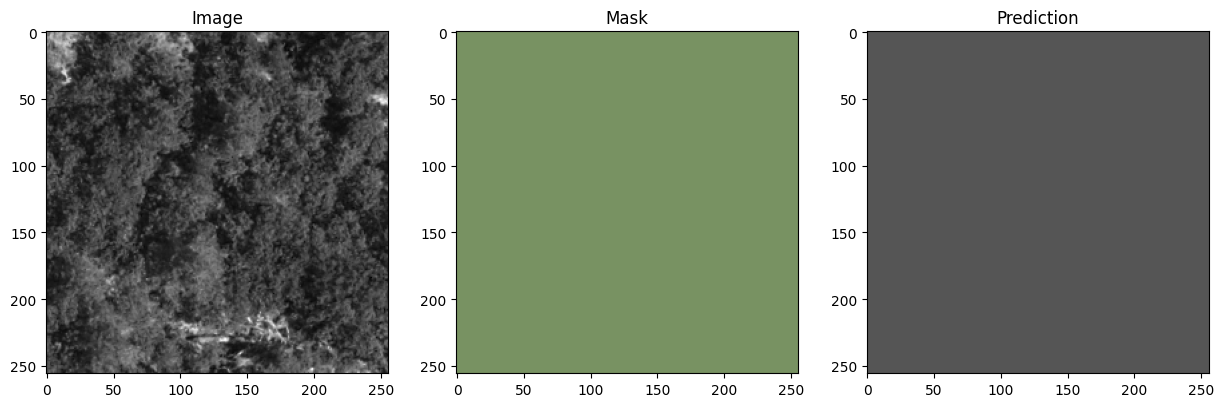

In [29]:
my_colors_map = {1: '#789262', 2: '#ff4500', 3: '#006400', 4: '#00ff00', 5: '#555555', 6: '#8a2be2'}


#plot img, original mask and prediction
model.eval()
img, msk = next(iter(test_dl))
img, msk = img.to(device), msk.to(device)
out = model(img)
out = torch.argmax(out, dim=1)
out = out.int()
img = img.cpu().numpy()
msk = msk.cpu().numpy()
out = out.cpu().numpy()
classes_msk = np.unique(msk)
legend_colors_msk = [my_colors_map[c] for c in classes_msk]
custom_cmap_msk = mcolors.ListedColormap(legend_colors_msk)
classes_out = np.unique(out)
legend_colors_out = [my_colors_map[c] for c in classes_out]
custom_cmap_out = mcolors.ListedColormap(legend_colors_out)
for i in range(16):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(img[i, 0], cmap='gray')
    ax[0].set_title('Image')
    ax[1].imshow(msk[i], cmap=custom_cmap_msk)
    ax[1].set_title('Mask')
    ax[2].imshow(out[i], cmap=custom_cmap_out)
    ax[2].set_title('Prediction')
    plt.show()

In [11]:
# continue training (did not cponverge)
model.load_state_dict(torch.load('../models/unet_last.pt'))
for param in model.parameters():
    param.to(device)
optimizer.load_state_dict(torch.load('../models/optim_last.pt'))

training_losses = []
validation_losses = []
training_iou = []
validation_iou = []

# implement early stopping with patience 4
for epoch in range(settings_dict['nb_epochs'], 30):
    print(f'Epoch {epoch+1}/30')
    model.to(device)
    model.train()
    train_loss, train_mIoU = train(model, train_dl, criterion, optimizer, device)
    training_losses.append(train_loss)
    training_iou.append(train_mIoU)

    model.eval()
    with torch.no_grad():
        val_loss, val_mIoU = valid(model, val_dl, criterion, device)    
        validation_losses.append(val_loss)
        validation_iou.append(val_mIoU)

    print(f'Epoch {epoch+1}/30: train loss {train_loss:.4f}, val loss {val_loss:.4f}')
    print(f'Epoch {epoch+1}/30: train mIoU {train_mIoU:.4f}, val mIoU {val_mIoU:.4f}')

    torch.save(model.state_dict(), f'../models/unet_{epoch}.pt')
        
    if len(validation_losses) > 4:
        if validation_losses[-1] > validation_losses[-2] > validation_losses[-3] > validation_losses[-4] > validation_losses[-5]:
            break

Epoch 11/30
Training
Batch: 0  over  347
Batch: 50  over  347
Batch: 100  over  347
Batch: 150  over  347
Batch: 200  over  347
Batch: 250  over  347
Batch: 300  over  347
Validation
Batch: 0  over  116
Batch: 50  over  116
Batch: 100  over  116
Epoch 11/30: train loss 0.7947, val loss 0.8990
Epoch 11/30: train mIoU 0.7131, val mIoU 0.6955
Epoch 12/30
Training
Batch: 0  over  347
Batch: 50  over  347
Batch: 100  over  347
Batch: 150  over  347
Batch: 200  over  347
Batch: 250  over  347
Batch: 300  over  347
Validation
Batch: 0  over  116
Batch: 50  over  116
Batch: 100  over  116
Epoch 12/30: train loss 0.7890, val loss 0.8339
Epoch 12/30: train mIoU 0.7162, val mIoU 0.7154
Epoch 13/30
Training
Batch: 0  over  347
Batch: 50  over  347
Batch: 100  over  347
Batch: 150  over  347
Batch: 200  over  347
Batch: 250  over  347
Batch: 300  over  347
Validation
Batch: 0  over  116
Batch: 50  over  116
Batch: 100  over  116
Epoch 13/30: train loss 0.7672, val loss 0.8031
Epoch 13/30: train mIo

In [12]:
# save last model state and optim
torch.save(model.state_dict(), f'../models/unet_last_30.pt')
torch.save(optimizer.state_dict(), f'../models/optim_last_30.pt')


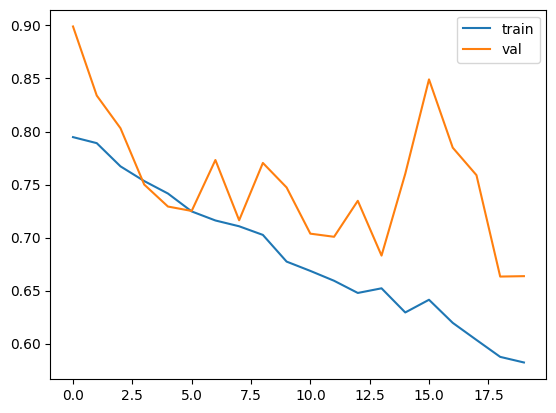

In [13]:
#plot losses
plt.plot(training_losses, label='train')
plt.plot(validation_losses, label='val')
plt.legend()
plt.show()

In [14]:
# test
model.eval()
with torch.no_grad():
    test_loss, test_mIoU = test(model, test_dl, criterion, device)
print(f'Test mIoU: {test_mIoU:.4f}')

Testing
Batch: 0  over  116
Batch: 50  over  116
Batch: 100  over  116
Test mIoU: 0.7667


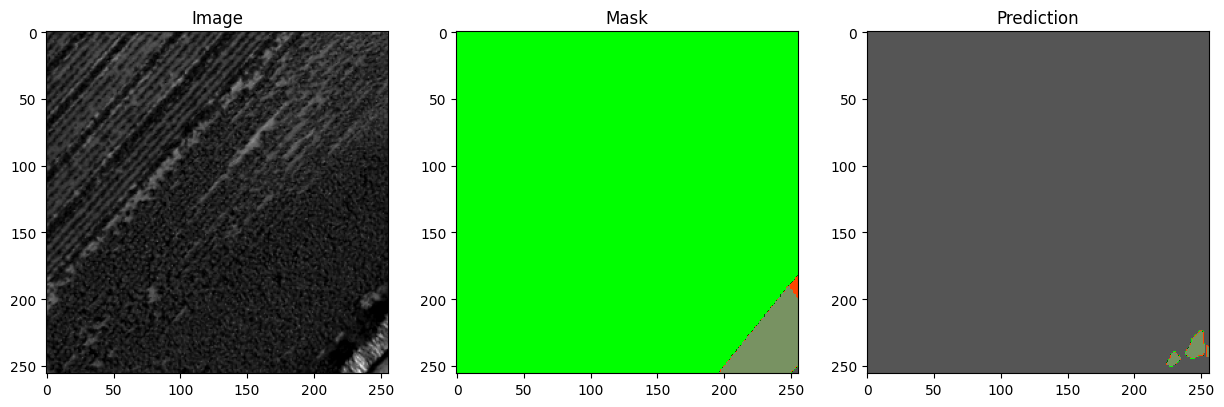

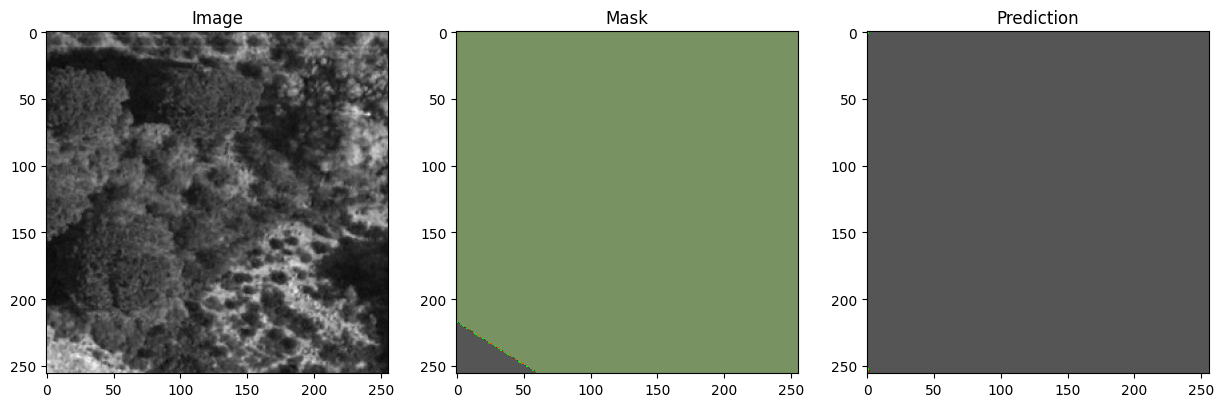

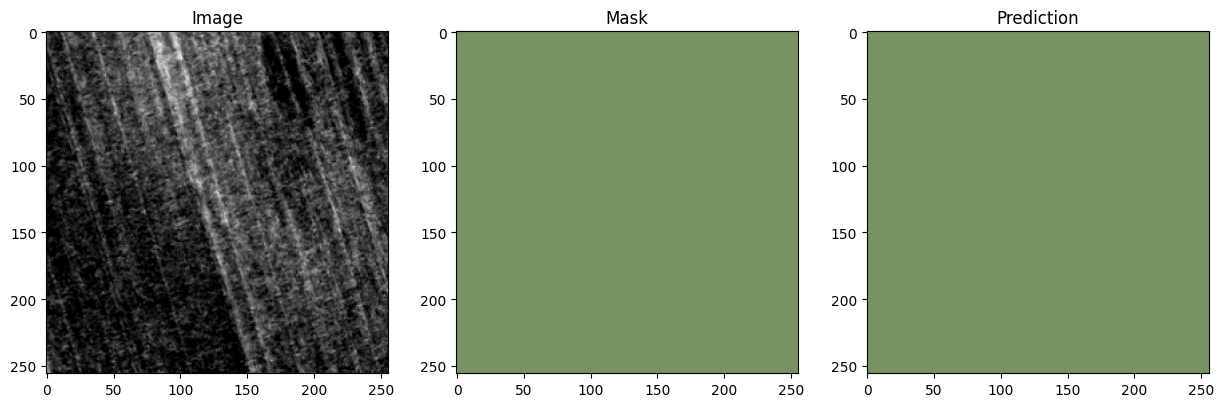

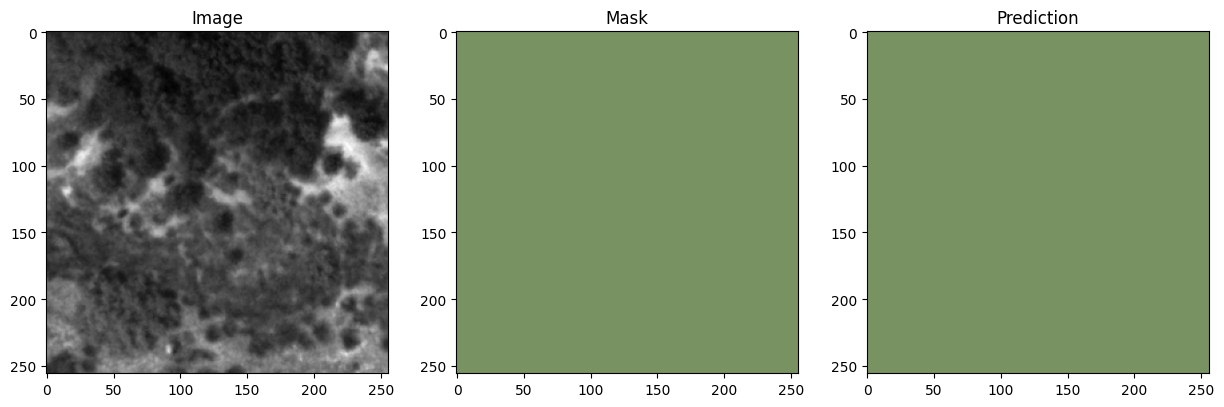

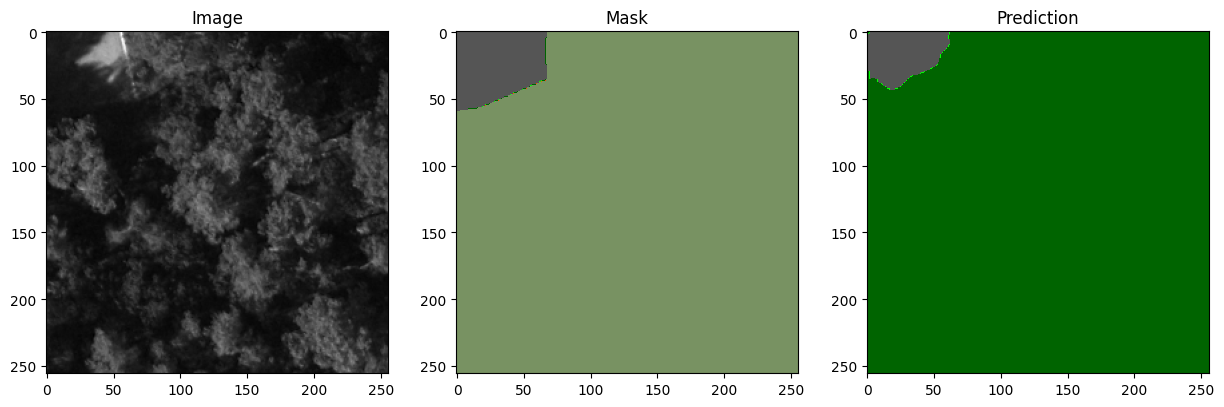

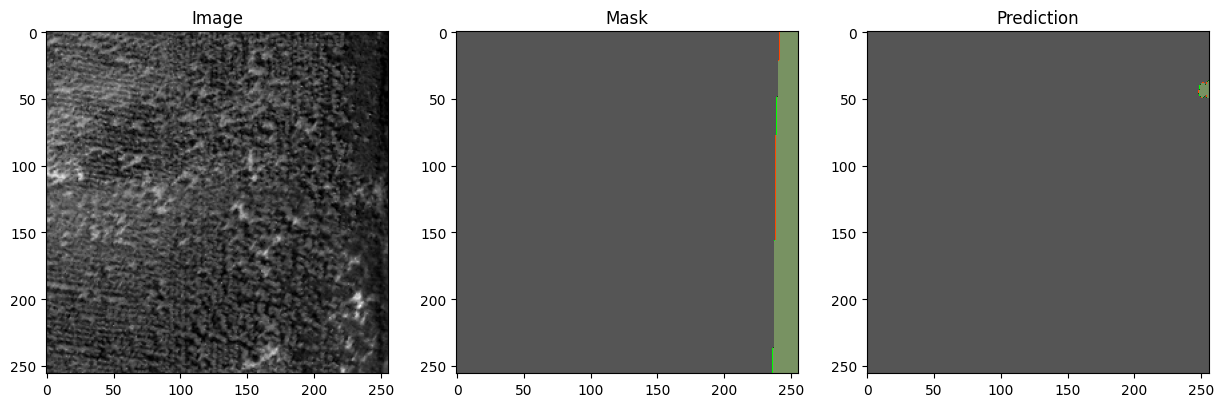

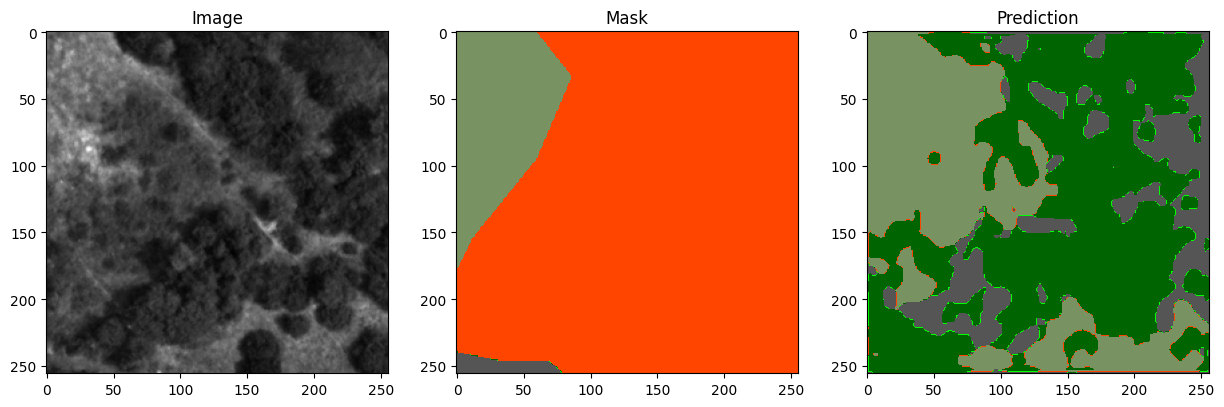

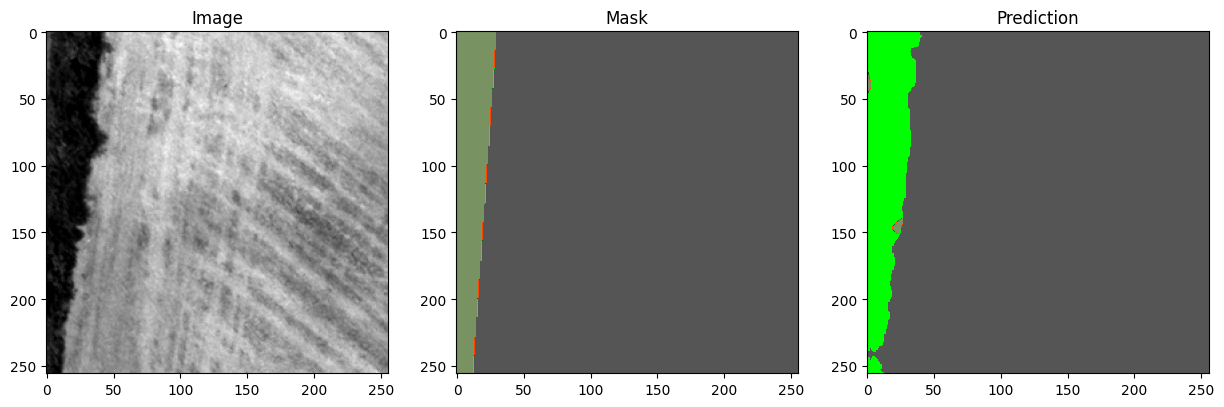

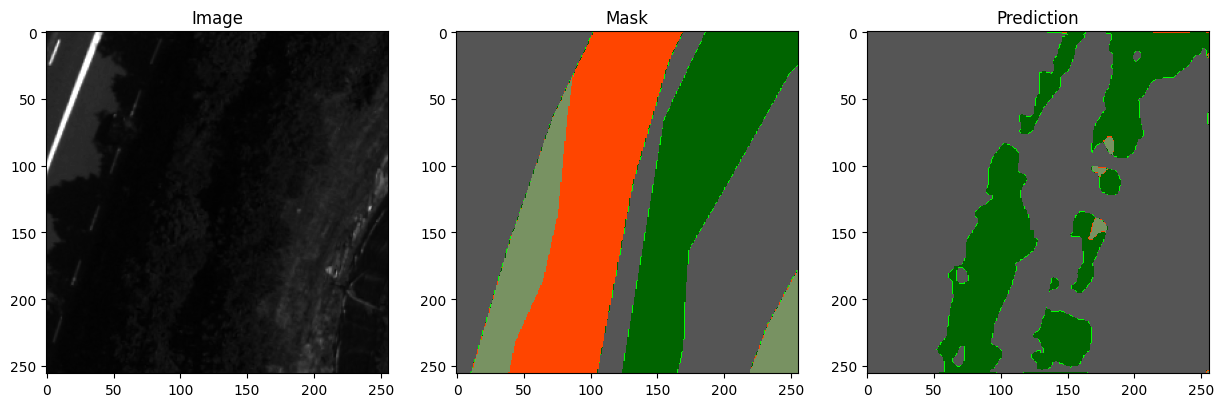

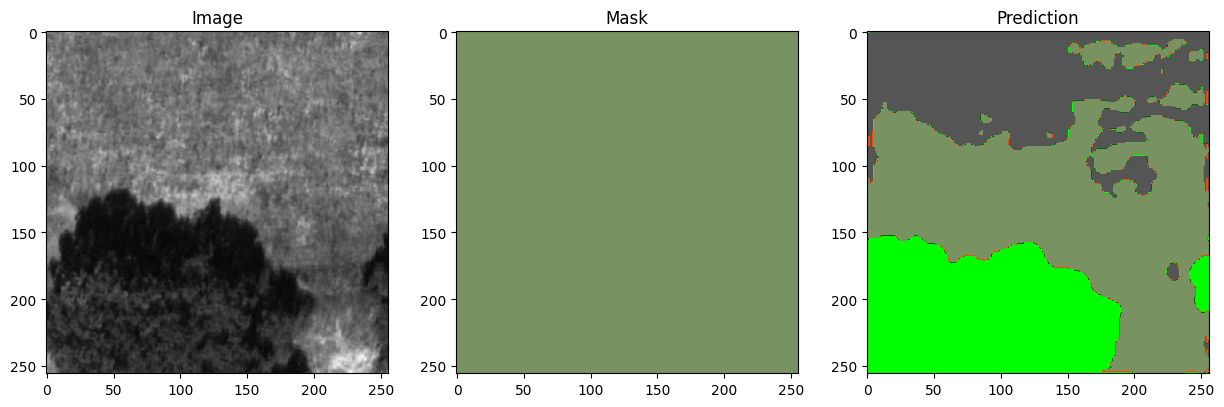

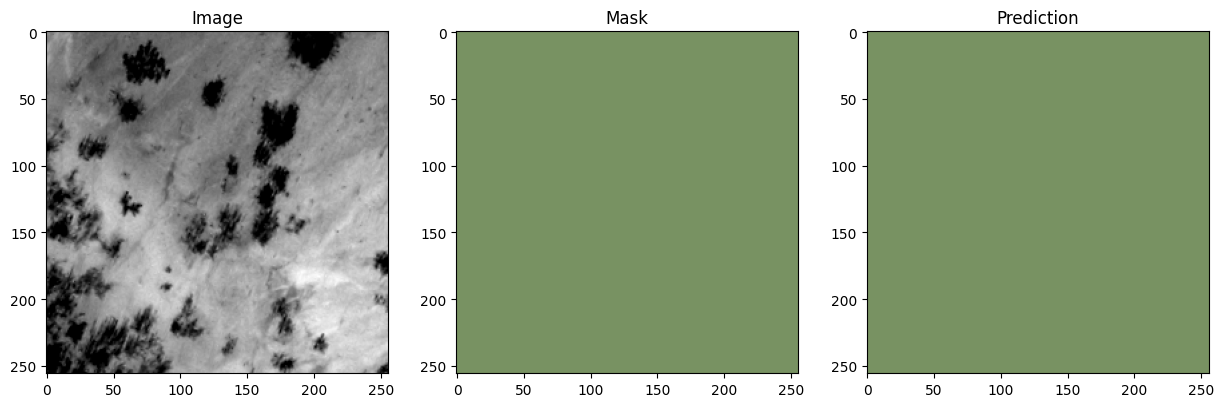

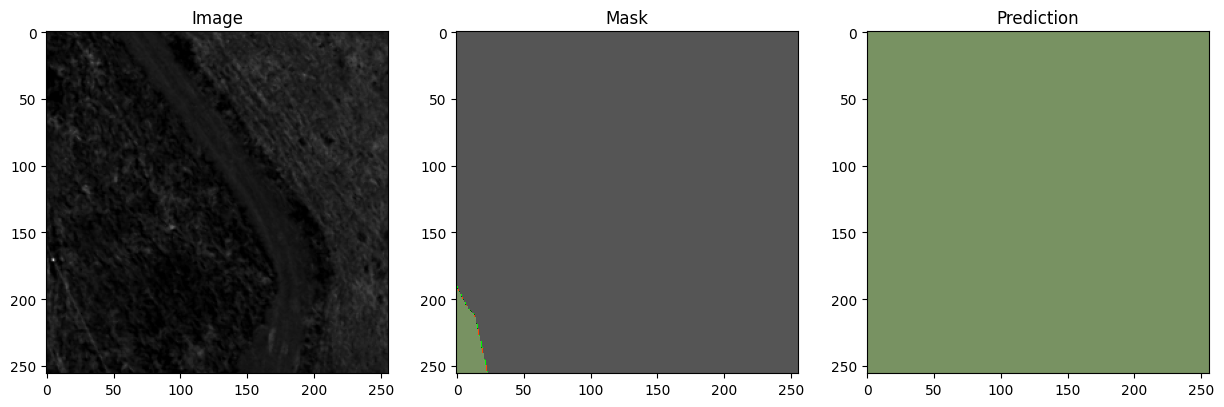

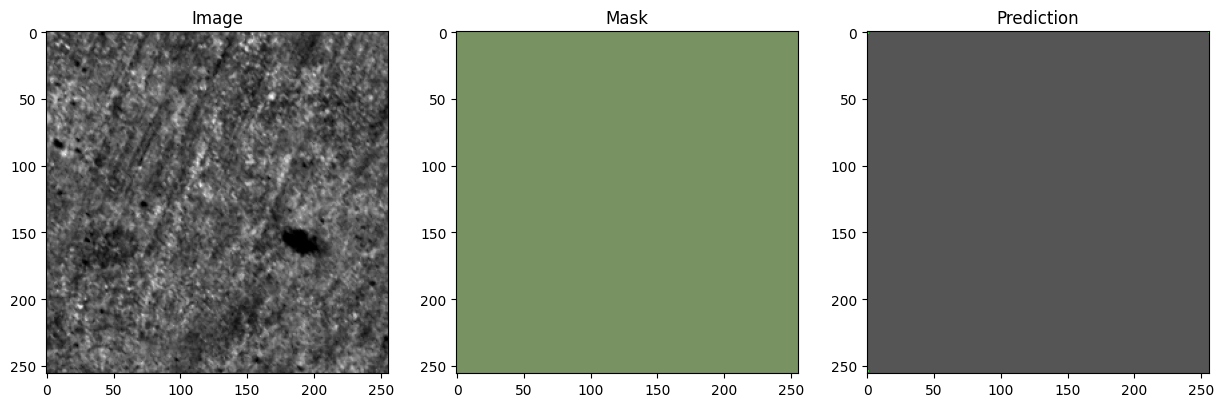

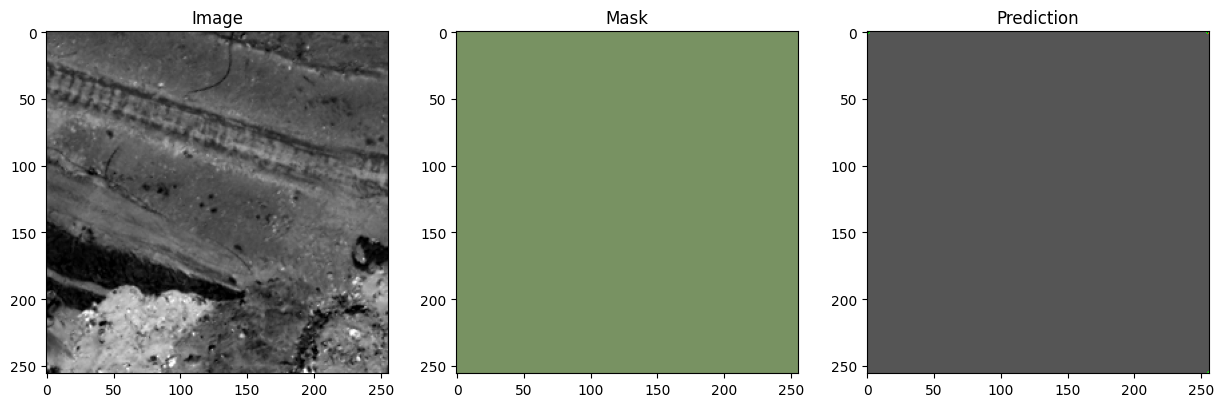

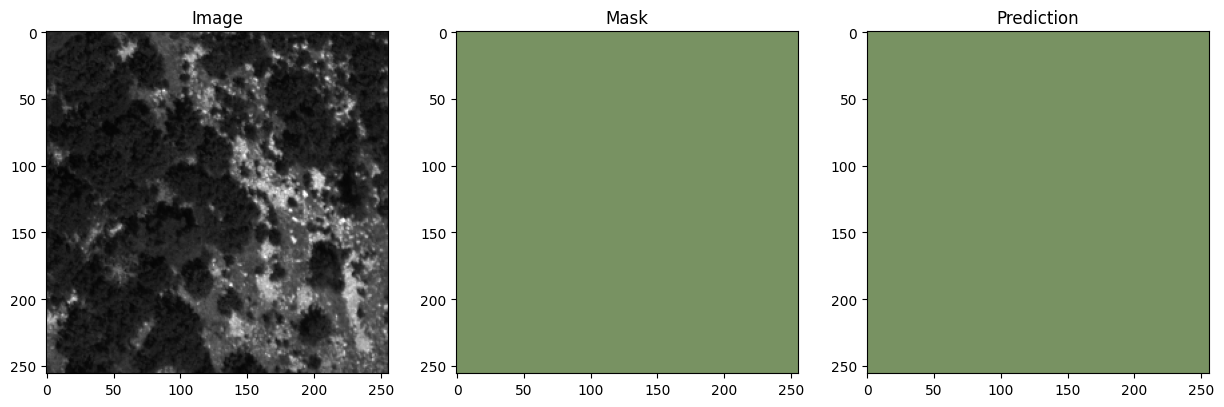

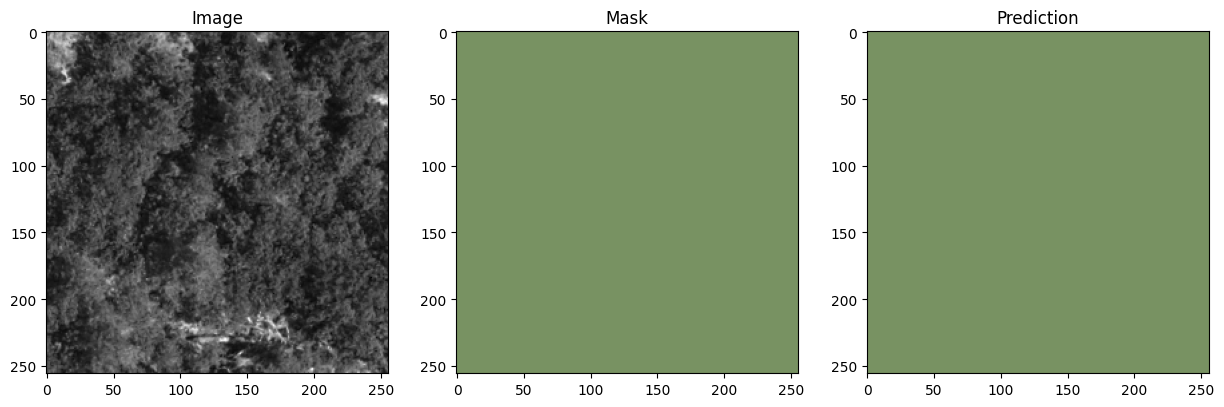

In [16]:
my_colors_map = {1: '#789262', 2: '#ff4500', 3: '#006400', 4: '#00ff00', 5: '#555555', 6: '#8a2be2'}

#plot img, original mask and prediction
model.eval()
img, msk = next(iter(test_dl))
img, msk = img.to(device), msk.to(device)
out = model(img)
out = torch.argmax(out, dim=1)
out = out.int()
img = img.cpu().numpy()
msk = msk.cpu().numpy()
out = out.cpu().numpy()
classes_msk = np.unique(msk)
legend_colors_msk = [my_colors_map[c] for c in classes_msk]
custom_cmap_msk = mcolors.ListedColormap(legend_colors_msk)
classes_out = np.unique(out)
legend_colors_out = [my_colors_map[c] for c in classes_out]
custom_cmap_out = mcolors.ListedColormap(legend_colors_out)
for i in range(16):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(img[i, 0], cmap='gray')
    ax[0].set_title('Image')
    ax[1].imshow(msk[i], cmap=custom_cmap_msk)
    ax[1].set_title('Mask')
    ax[2].imshow(out[i], cmap=custom_cmap_out)
    ax[2].set_title('Prediction')
    plt.show()